# **IMPORTANDO E ANALISANDO OS DADOS**

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("StudentsPerformance.csv")
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


**Verificando se há dados nulos:**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [4]:
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [5]:
df.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

**Verificando se há dados duplicados:**

In [6]:
df.duplicated().sum()

0

**Vamos criar uma coluna de média das notas que servirá como target:**

In [7]:
curso_notas = df[["test preparation course", "math score", "reading score", "writing score"]]
df_notas = df[["math score", "reading score", "writing score"]]

In [8]:
lista_col = []
lista_media = []
for col in df_notas:
    lista_col.append(col)
for num in range(len(df_notas)):
  media = (df_notas[lista_col[0]].iloc[num] + df_notas[lista_col[1]].iloc[num] + df_notas[lista_col[2]].iloc[num])/3
  lista_media.append(media)
curso_notas["media"] = lista_media
df["media"] = lista_media
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


# **ADABOOST**

## **Black Box - Usando o Random Forest como estimador**

In [74]:
from sklearn.ensemble import RandomForestRegressor
#Separando o que é features e target:
X = df.drop(columns="media")
y = df["media"]

# Dividindo em dados de teste e dados de treino, peguei 20% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Iniciando a construção da Pipeline:
# ==========================================================
#Primeiro vamos tratar as features numéricas. Tratando os valores nulos (NaN) e escalonando já que a variância entre as features é grande.
pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                              ("std", StandardScaler())])

features_num = X_train.select_dtypes(include=np.number).columns.tolist()
# ==========================================================
# ==========================================================
# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos pelos dados mais constantes e posteriormente codificaremos todas elas com Ordinal Enconder. 

pipe_features_oe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                            ("ordinal", OrdinalEncoder())])

features_oe = ["race/ethnicity", "parental level of education"]

# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos pelos dados mais constantes e posteriormente codificaremos todas elas com o One Hot Encoder. 

pipe_features_ohe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                            ("onehot", OneHotEncoder(handle_unknown='ignore'))])

features_ohe = ["gender", "lunch", "test preparation course"]
# ==========================================================
# Pré-processador => Pegando as pipelines anteriores e unindo-as.
pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_cat", pipe_features_oe, features_oe)])

# ==========================================================
# pipeline final
pipe_ada = Pipeline([("pre_processador", pre_processador),
                    ("ada", AdaBoostRegressor(base_estimator=RandomForestRegressor(max_depth=2)))])

#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
# =====================================

params_grid_ada = {"ada__n_estimators": [1000, 5000,10000]} 


#Motando a grade geral de parâmetros.
grid_ada_rfr = GridSearchCV(estimator=pipe_ada,
                       param_grid=params_grid_ada,
                       scoring="r2",
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

grid_ada_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['math '
                                                                          'score',
                                                                          'reading '
                                                                          'score',
                                    

In [75]:
grid_ada_rfr.best_params_

{'ada__n_estimators': 1000}

In [76]:
xgbr_results = pd.DataFrame(grid_ada_rfr.cv_results_)
xgbr_results.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ada__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,75.151709,24.514906,4.822580,2.096535,1000,{'ada__n_estimators': 1000},0.968457,0.965115,0.970880,0.976942,0.970477,0.970374,0.003866,1
2,90.605288,68.700234,4.987521,3.707045,10000,{'ada__n_estimators': 10000},0.972564,0.958559,0.972264,0.974472,0.971488,0.969869,0.005740,2
1,100.952695,71.096071,4.883805,2.667755,5000,{'ada__n_estimators': 5000},0.969731,0.963034,0.971898,0.974217,0.969644,0.969705,0.003733,3


In [77]:
# Predições de treino
y_pred_train = grid_ada_rfr.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

# Predições de teste
y_pred_test = grid_ada_rfr.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Métricas de treino:

R^2: 0.97
MAE: 2.20
RMSE: 2.59

Métricas de teste:

R^2: 0.97
MAE: 1.97
RMSE: 2.38




---



**Nos dois gráficos abaixos percebemos que os dados de treinos não gabaritaram(não gravaram a resposta) e, sim, geraram erros extremamentes pequenos. Isso se dá pela coesão dos dados. Podemos ver pela MAE que se houvesse gabaritado as respostas (overfitting) os dados de teste não gerariam erros.**

Peguei um exemplo:

In [78]:
df.iloc[[0]]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667


In [79]:
grid_ada_rfr.predict(df.iloc[[0]])


array([71.02789965])



---



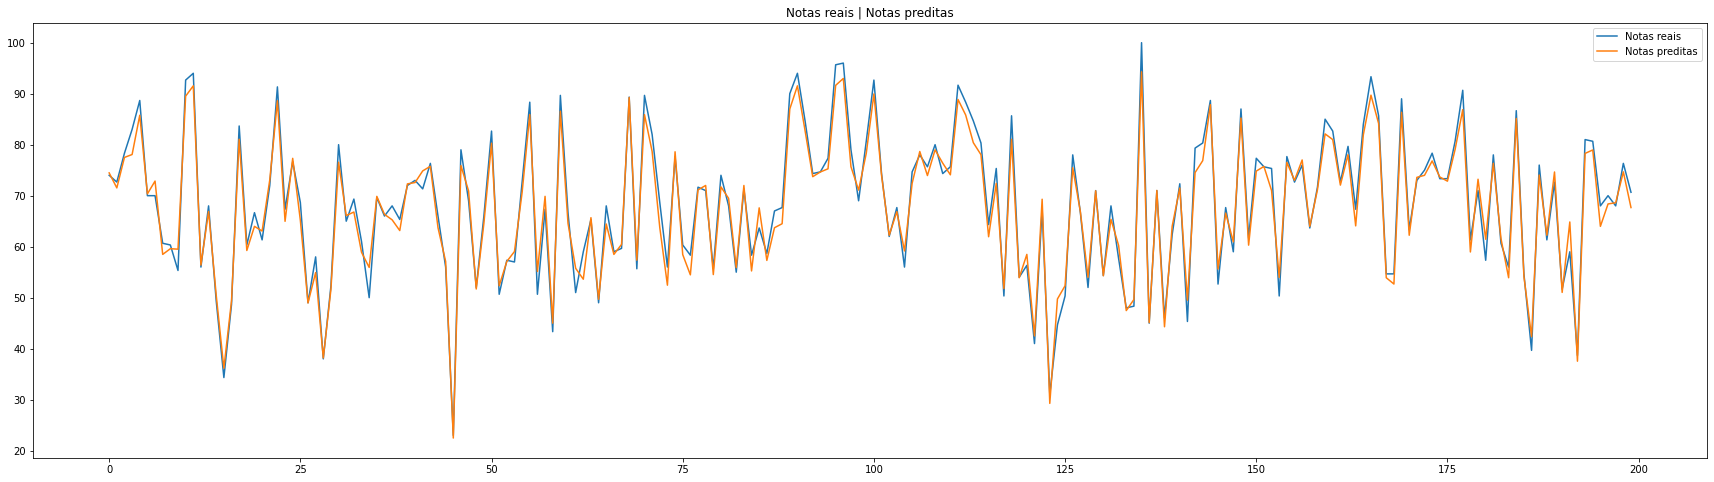

In [80]:
plt.figure(figsize=(30,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Notas reais")
plt.plot(x_ax, y_pred_test, label="Notas preditas")
plt.title("Notas reais | Notas preditas")
plt.legend()
plt.show();

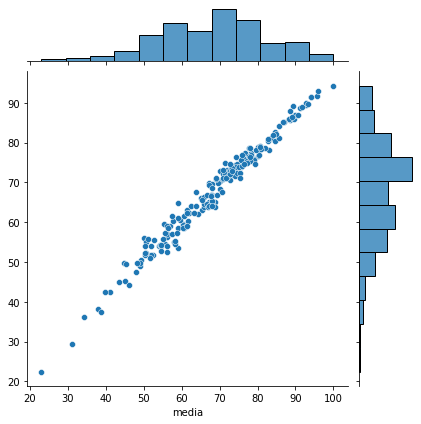

In [81]:
sns.jointplot(y_test, y_pred_test)
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos");

In [82]:
import pickle

In [83]:
with open("grid_ada_rfr.pkl", "wb") as f:
    pickle.dump(grid_ada_rfr, f)

In [63]:
with open("grid_ada_rfr.pkl", "rb") as f:
    
    grid_ada_rfr = pickle.load(f)

**Vamos criar uma tabela com a porcentagem de acertos para cada dado**

In [84]:
tabela = pd.DataFrame()

In [85]:
tabela["valores reais"] = y_test

In [86]:
tabela["valores preditos"] = y_pred_test

In [87]:
tabela

,valores reais,valores preditos
518,74.000000,74.468576
871,72.666667,71.524328
797,78.333333,77.503036
274,83.000000,78.070872
325,88.666667,85.771052
...,...,...
909,68.000000,63.985050
757,70.000000,68.379815
965,68.000000,68.612907
4,76.333333,74.667789


In [88]:
tabela.to_csv("07_educacao_rfr.csv")

## **Intervalo de confiança do ADABoost - Vamos simular intervalos para amostras com 30 e 100 dados:**

In [89]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import norm
from scipy import stats
from scipy.stats import t

In [91]:
df = pd.read_csv("StudentsPerformance.csv")

In [92]:
curso_notas = df[["test preparation course", "math score", "reading score", "writing score"]]
df_notas = df[["math score", "reading score", "writing score"]]

In [93]:
lista_col = []
lista_media = []
for col in df_notas:
    lista_col.append(col)
for num in range(len(df_notas)):
  media = (df_notas[lista_col[0]].iloc[num] + df_notas[lista_col[1]].iloc[num] + df_notas[lista_col[2]].iloc[num])/3
  lista_media.append(media)
curso_notas["media"] = lista_media
df["media"] = lista_media
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [94]:
oe =  OrdinalEncoder()
oe.fit(df[["gender", "test preparation course", "lunch", "race/ethnicity", "parental level of education"]])

df[["gender", "test preparation course", "lunch", "race/ethnicity", "parental level of education"]] = oe.transform(df[["gender", "test preparation course", "lunch", "race/ethnicity", "parental level of education"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [ ]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'media'],
      dtype='object')

In [95]:
ssc = StandardScaler()

ssc.fit(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score','writing score']])
h= ssc.transform(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']])
df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']] = h

In [96]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,-0.964625,-1.015044,-0.812640,0.741881,0.746748,0.390024,0.193999,0.391492,72.666667
1,-0.964625,-0.150441,0.827953,0.741881,-1.339140,0.192076,1.427476,1.313269,82.333333
2,-0.964625,-1.015044,0.281088,0.741881,0.746748,1.577711,1.770109,1.642475,92.666667
3,1.036672,-1.879647,-1.359505,-1.347925,0.746748,-1.259543,-0.833899,-1.583744,49.333333
4,1.036672,-0.150441,0.827953,0.741881,0.746748,0.653954,0.605158,0.457333,76.333333
...,...,...,...,...,...,...,...,...,...
995,-0.964625,1.578765,0.281088,0.741881,-1.339140,1.445746,2.044215,1.774157,94.000000
996,1.036672,-0.150441,-0.265776,-1.347925,0.746748,-0.269803,-0.970952,-0.859491,57.333333
997,-0.964625,-0.150441,-0.265776,-1.347925,-1.339140,-0.467751,0.125472,-0.201079,65.000000
998,-0.964625,0.714162,0.827953,0.741881,-1.339140,0.126093,0.605158,0.589015,74.333333


In [97]:
#Separando o que é features e target:
X = df.drop(columns="media")
y = df["media"]

In [98]:
X = np.array(X)

**Com 30 e 90 amostras**

In [99]:
resultados_ada_cv_30 = []
resultados_ada_cv_100 = []
for i in range(10):
  kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
  
  ada = AdaBoostRegressor()
  scores = cross_val_score(ada, X, y, cv = kfold)
  resultados_ada_cv_100.append(scores)
  resultados_ada_cv_30.append(scores.mean())

In [100]:
scores

array([0.97162315, 0.98423708, 0.98101606, 0.98019888, 0.985085  ,
       0.97641701, 0.9776086 , 0.96925697, 0.98228414, 0.97823262])

In [101]:
resultados_ada_cv_30 = np.array(resultados_ada_cv_30)
resultados_ada_cv_100 = np.array(np.asarray(resultados_ada_cv_100).reshape(-1))

**Para 30 amostras usamos o t-student:**

In [102]:
intervalos_ada_t = t.interval(0.95, len(resultados_ada_cv_30) - 1, 
                                    resultados_ada_cv_30.mean(), 
                                    stats.sem(resultados_ada_cv_30, ddof = 0))
intervalos_ada_t

(0.9782761586700786, 0.9790311478008882)

**Variação do intervalo:**

In [103]:
abs(resultados_ada_cv_30.mean() - intervalos_ada_t[1])

0.0003774945654048123

In [104]:
print(f"Temos 95% de confiança de que a média de acertos do ADABoost Regressor com 30 amostras está no intervalo entre {intervalos_ada_t[0]*100:.2f} % e {intervalos_ada_t[1]*100:.2f} % com variação de {abs(resultados_ada_cv_30.mean() - intervalos_ada_t[1])} para mais e para menos")

Temos 95% de confiança de que a média de acertos do ADABoost Regressor com 30 amostras está no intervalo entre 97.83 % e 97.90 % com variação de 0.0003774945654048123 para mais e para menos


**Média do score:**

In [105]:
pd.DataFrame(resultados_ada_cv_30).mean()[0]

0.9786536532354834



---



**Para 100 amostras**

In [106]:
intervalos_ada_n = norm.interval(0.95, resultados_ada_cv_100.mean(), 
                                       stats.sem(resultados_ada_cv_100))
intervalos_ada_n

(0.9778580982164905, 0.9794492082544762)

**Para 100 amostras ele acabou aumentando a margem de erro em relação ao de 30 amostras, o que é esperado.**

**Variação do intervalo:**

In [107]:
abs(resultados_ada_cv_100.mean() - intervalos_ada_n[1])

0.0007955550189928662

In [108]:
print(f"Temos 95% de confiança de que a média de acertos do ADAoost Regressor com 90 amostras está no intervalo entre {intervalos_ada_n[0]*100:.2f}% e {intervalos_ada_n[1]*100:.2f}%")

Temos 95% de confiança de que a média de acertos do ADAoost Regressor com 90 amostras está no intervalo entre 97.79% e 97.94%


**Média do score:**

In [109]:
resultado_100 = resultados_ada_cv_100
resultado_100 = (resultado_100[0] + resultado_100[1] + resultado_100[2])/3
resultado_100

0.9784466772325359

#**INTERPRETANDO O MODELO GLOBALMENTE**

**SHAP**

In [123]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,-0.964625,-1.015044,-0.812640,0.741881,0.746748,0.390024,0.193999,0.391492,72.666667
1,-0.964625,-0.150441,0.827953,0.741881,-1.339140,0.192076,1.427476,1.313269,82.333333
2,-0.964625,-1.015044,0.281088,0.741881,0.746748,1.577711,1.770109,1.642475,92.666667
3,1.036672,-1.879647,-1.359505,-1.347925,0.746748,-1.259543,-0.833899,-1.583744,49.333333
4,1.036672,-0.150441,0.827953,0.741881,0.746748,0.653954,0.605158,0.457333,76.333333
...,...,...,...,...,...,...,...,...,...
995,-0.964625,1.578765,0.281088,0.741881,-1.339140,1.445746,2.044215,1.774157,94.000000
996,1.036672,-0.150441,-0.265776,-1.347925,0.746748,-0.269803,-0.970952,-0.859491,57.333333
997,-0.964625,-0.150441,-0.265776,-1.347925,-1.339140,-0.467751,0.125472,-0.201079,65.000000
998,-0.964625,0.714162,0.827953,0.741881,-1.339140,0.126093,0.605158,0.589015,74.333333


In [124]:
X = df.drop(columns=["media"])
y = df["media"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [ ]:
!pip install shap
import shap

In [139]:
rfr = RandomForestRegressor().fit(X_train, y_train)

In [141]:
explainer = shap.TreeExplainer(rfr)

In [142]:
shap_vals = explainer.shap_values(X_train)

**Temos abaixo as Features que mais impactaram na escolha dos valores preditivos para todos os dados:**

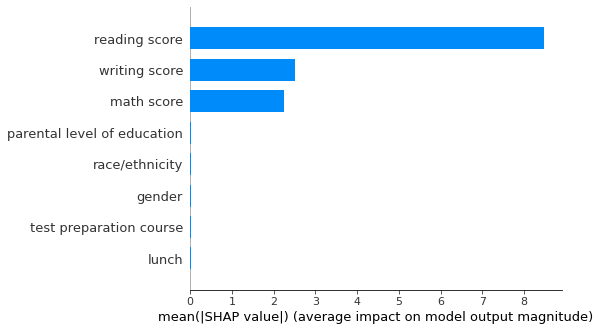

In [143]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")